In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math



In [78]:
excel_file_path = 'budgetusd.xlsx'

sheet_name = "Revenue"

df = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Load the Excel file into a pandas DataFrame

df

,Date,Percentage %,Holidays Local,Winter North,Holidays North,Local Rainy Season,International Flights,Marketing,Average F&B,ARR,Resturant Revenue,Bar Revenue,Rooms Revenue,Total Revenue
0,2022-01,0.61,3,Yes,7,No,1,62.111111,15,75,7771.638889,3972.555556,13136.888889,24881.083333
1,2022-02,0.62,1,Yes,0,No,1,62.111111,15,75,5660.000000,3773.333333,11430.527778,20863.861111
2,2022-03,0.39,0,Yes,0,No,1,99.305556,15,75,5299.861111,3533.222222,9742.611111,18575.694444
3,2022-04,0.70,5,No,0,No,1,246.055556,15,75,11300.750000,7533.833333,15043.805556,33878.388889
4,2022-05,0.47,1,No,0,Medium,1,144.920389,15,75,5555.010000,3703.340000,8546.169167,17804.519167
5,2022-06,0.33,0,No,0,Medium,1,118.458222,15,75,2821.991944,1881.328056,7171.419167,11874.739167
6,2022-07,0.67,3,No,20,Medium,1,46.761375,17,75,6345.989444,4230.659722,15864.973889,26441.623056
7,2022-08,0.49,2,No,10,Medium,1,149.967917,17,77,5398.003139,3598.668611,11925.820833,20922.492583
8,2022-09,0.51,3,No,0,Yes,1,170.240833,17,77,5495.210667,3663.473778,13738.026667,22896.711111
9,2022-10,0.40,0,No,0,Yes,1,176.074631,17,77,3969.148564,2646.099042,7765.725450,14380.973056


In [79]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   24 non-null     object 
 1   Percentage %           24 non-null     float64
 2   Holidays Local         24 non-null     float64
 3   Winter North           24 non-null     object 
 4   Holidays North         24 non-null     float64
 5   Local Rainy Season     24 non-null     object 
 6   International Flights  24 non-null     float64
 7   Marketing              24 non-null     float64
 8   Average F&B            24 non-null     float64
 9   ARR                    24 non-null     float64
 10  Resturant Revenue      24 non-null     float64
 11  Bar Revenue            24 non-null     float64
 12  Rooms Revenue          24 non-null     float64
 13  Total Revenue          24 non-null     float64
dtypes: float64(11), object(3)
memory usage: 2.8+ KB


In [13]:
df.info()
df.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   24 non-null     object 
 1   Percentage %           20 non-null     float64
 2   Holidays Local         24 non-null     float64
 3   Winter North           24 non-null     object 
 4   Holidays North         24 non-null     float64
 5    Local Rainy Season    24 non-null     object 
 6   International Flights  24 non-null     float64
 7   Marketing              24 non-null     float64
 8   Resturant Revenue      20 non-null     float64
 9   Bar Revenue            20 non-null     float64
 10  Rooms Revenue          20 non-null     float64
 11  Total Revenue          20 non-null     float64
dtypes: float64(9), object(3)
memory usage: 2.4+ KB


RangeIndex(start=0, stop=24, step=1)

In [87]:
# Repace Yes/No/Medium values from Winter North and Rainy Season variables

column_replacements = {
    'Winter North': {"Yes": 1, "No": 0},
    'Local Rainy Season': {"No": 0, "Medium": 1, "Yes": 2}  # Map integer 1 to 1 and string values to appropriate numbers
}

for col, replacements in column_replacements.items():
    df[col] = df[col].replace(replacements)

In [88]:
print(df['Local Rainy Season'].unique())


[0 1 2]


In [89]:
df

,Date,Percentage %,Holidays Local,Winter North,Holidays North,Local Rainy Season,International Flights,Marketing,Average F&B,ARR,Resturant Revenue,Bar Revenue,Rooms Revenue,Total Revenue
0,2022-01,0.61,3.0,1,7.0,0,1.0,62.12,15.0,75.0,7771.64,3972.56,13136.89,24881.09
1,2022-02,0.62,1.0,1,0.0,0,1.0,62.12,15.0,75.0,5660.00,3773.34,11430.53,20863.87
2,2022-03,0.39,0.0,1,0.0,0,1.0,99.31,15.0,75.0,5299.87,3533.23,9742.62,18575.70
3,2022-04,0.70,5.0,0,0.0,0,1.0,246.06,15.0,75.0,11300.75,7533.84,15043.81,33878.39
4,2022-05,0.47,1.0,0,0.0,1,1.0,144.93,15.0,75.0,5555.01,3703.34,8546.17,17804.52
5,2022-06,0.33,0.0,0,0.0,1,1.0,118.46,15.0,75.0,2822.00,1881.33,7171.42,11874.74
6,2022-07,0.67,3.0,0,20.0,1,1.0,46.77,17.0,75.0,6345.99,4230.66,15864.98,26441.63
7,2022-08,0.49,2.0,0,10.0,1,1.0,149.97,17.0,77.0,5398.01,3598.67,11925.83,20922.50
8,2022-09,0.51,3.0,0,0.0,2,1.0,170.25,17.0,77.0,5495.22,3663.48,13738.03,22896.72
9,2022-10,0.40,0.0,0,0.0,2,1.0,176.08,17.0,77.0,3969.15,2646.10,7765.73,14380.98


In [90]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Percentage %           24 non-null     float64
 1   Holidays Local         24 non-null     float64
 2   Winter North           24 non-null     int64  
 3   Holidays North         24 non-null     float64
 4   Local Rainy Season     24 non-null     int64  
 5   International Flights  24 non-null     float64
 6   Marketing              24 non-null     float64
 7   Average F&B            24 non-null     float64
 8   ARR                    24 non-null     float64
 9   Resturant Revenue      24 non-null     float64
 10  Bar Revenue            24 non-null     float64
 11  Rooms Revenue          24 non-null     float64
 12  Total Revenue          24 non-null     float64
dtypes: float64(11), int64(2)
memory usage: 2.6 KB


In [69]:
df

,Percentage %,Holidays Local,Winter North,Holidays North,Local Rainy Season,International Flights,Marketing,Resturant Revenue,Bar Revenue,Rooms Revenue,Total Revenue
Date,,,,,,,,,,,
2022-01-01,0.61,3.0,1,7.0,No,1.0,62.12,7771.64,3972.56,13136.89,24881.09
2022-02-01,0.62,1.0,1,0.0,No,1.0,62.12,5660.00,3773.34,11430.53,20863.87
2022-03-01,0.39,0.0,1,0.0,No,1.0,99.31,5299.87,3533.23,9742.62,18575.70
2022-04-01,0.70,5.0,0,0.0,No,1.0,246.06,11300.75,7533.84,15043.81,33878.39
2022-05-01,0.47,1.0,0,0.0,1,1.0,144.93,5555.01,3703.34,8546.17,17804.52
2022-06-01,0.33,0.0,0,0.0,1,1.0,118.46,2822.00,1881.33,7171.42,11874.74
2022-07-01,0.67,3.0,0,20.0,1,1.0,46.77,6345.99,4230.66,15864.98,26441.63
2022-08-01,0.49,2.0,0,10.0,1,1.0,149.97,5398.01,3598.67,11925.83,20922.50
2022-09-01,0.51,3.0,0,0.0,Yes,1.0,170.25,5495.22,3663.48,13738.03,22896.72


In [92]:
df.isnull().sum()

Percentage %             0
Holidays Local           0
Winter North             0
Holidays North           0
Local Rainy Season       0
International Flights    0
Marketing                0
Average F&B              0
ARR                      0
Resturant Revenue        0
Bar Revenue              0
Rooms Revenue            0
Total Revenue            0
dtype: int64

### Correlation Analysis

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


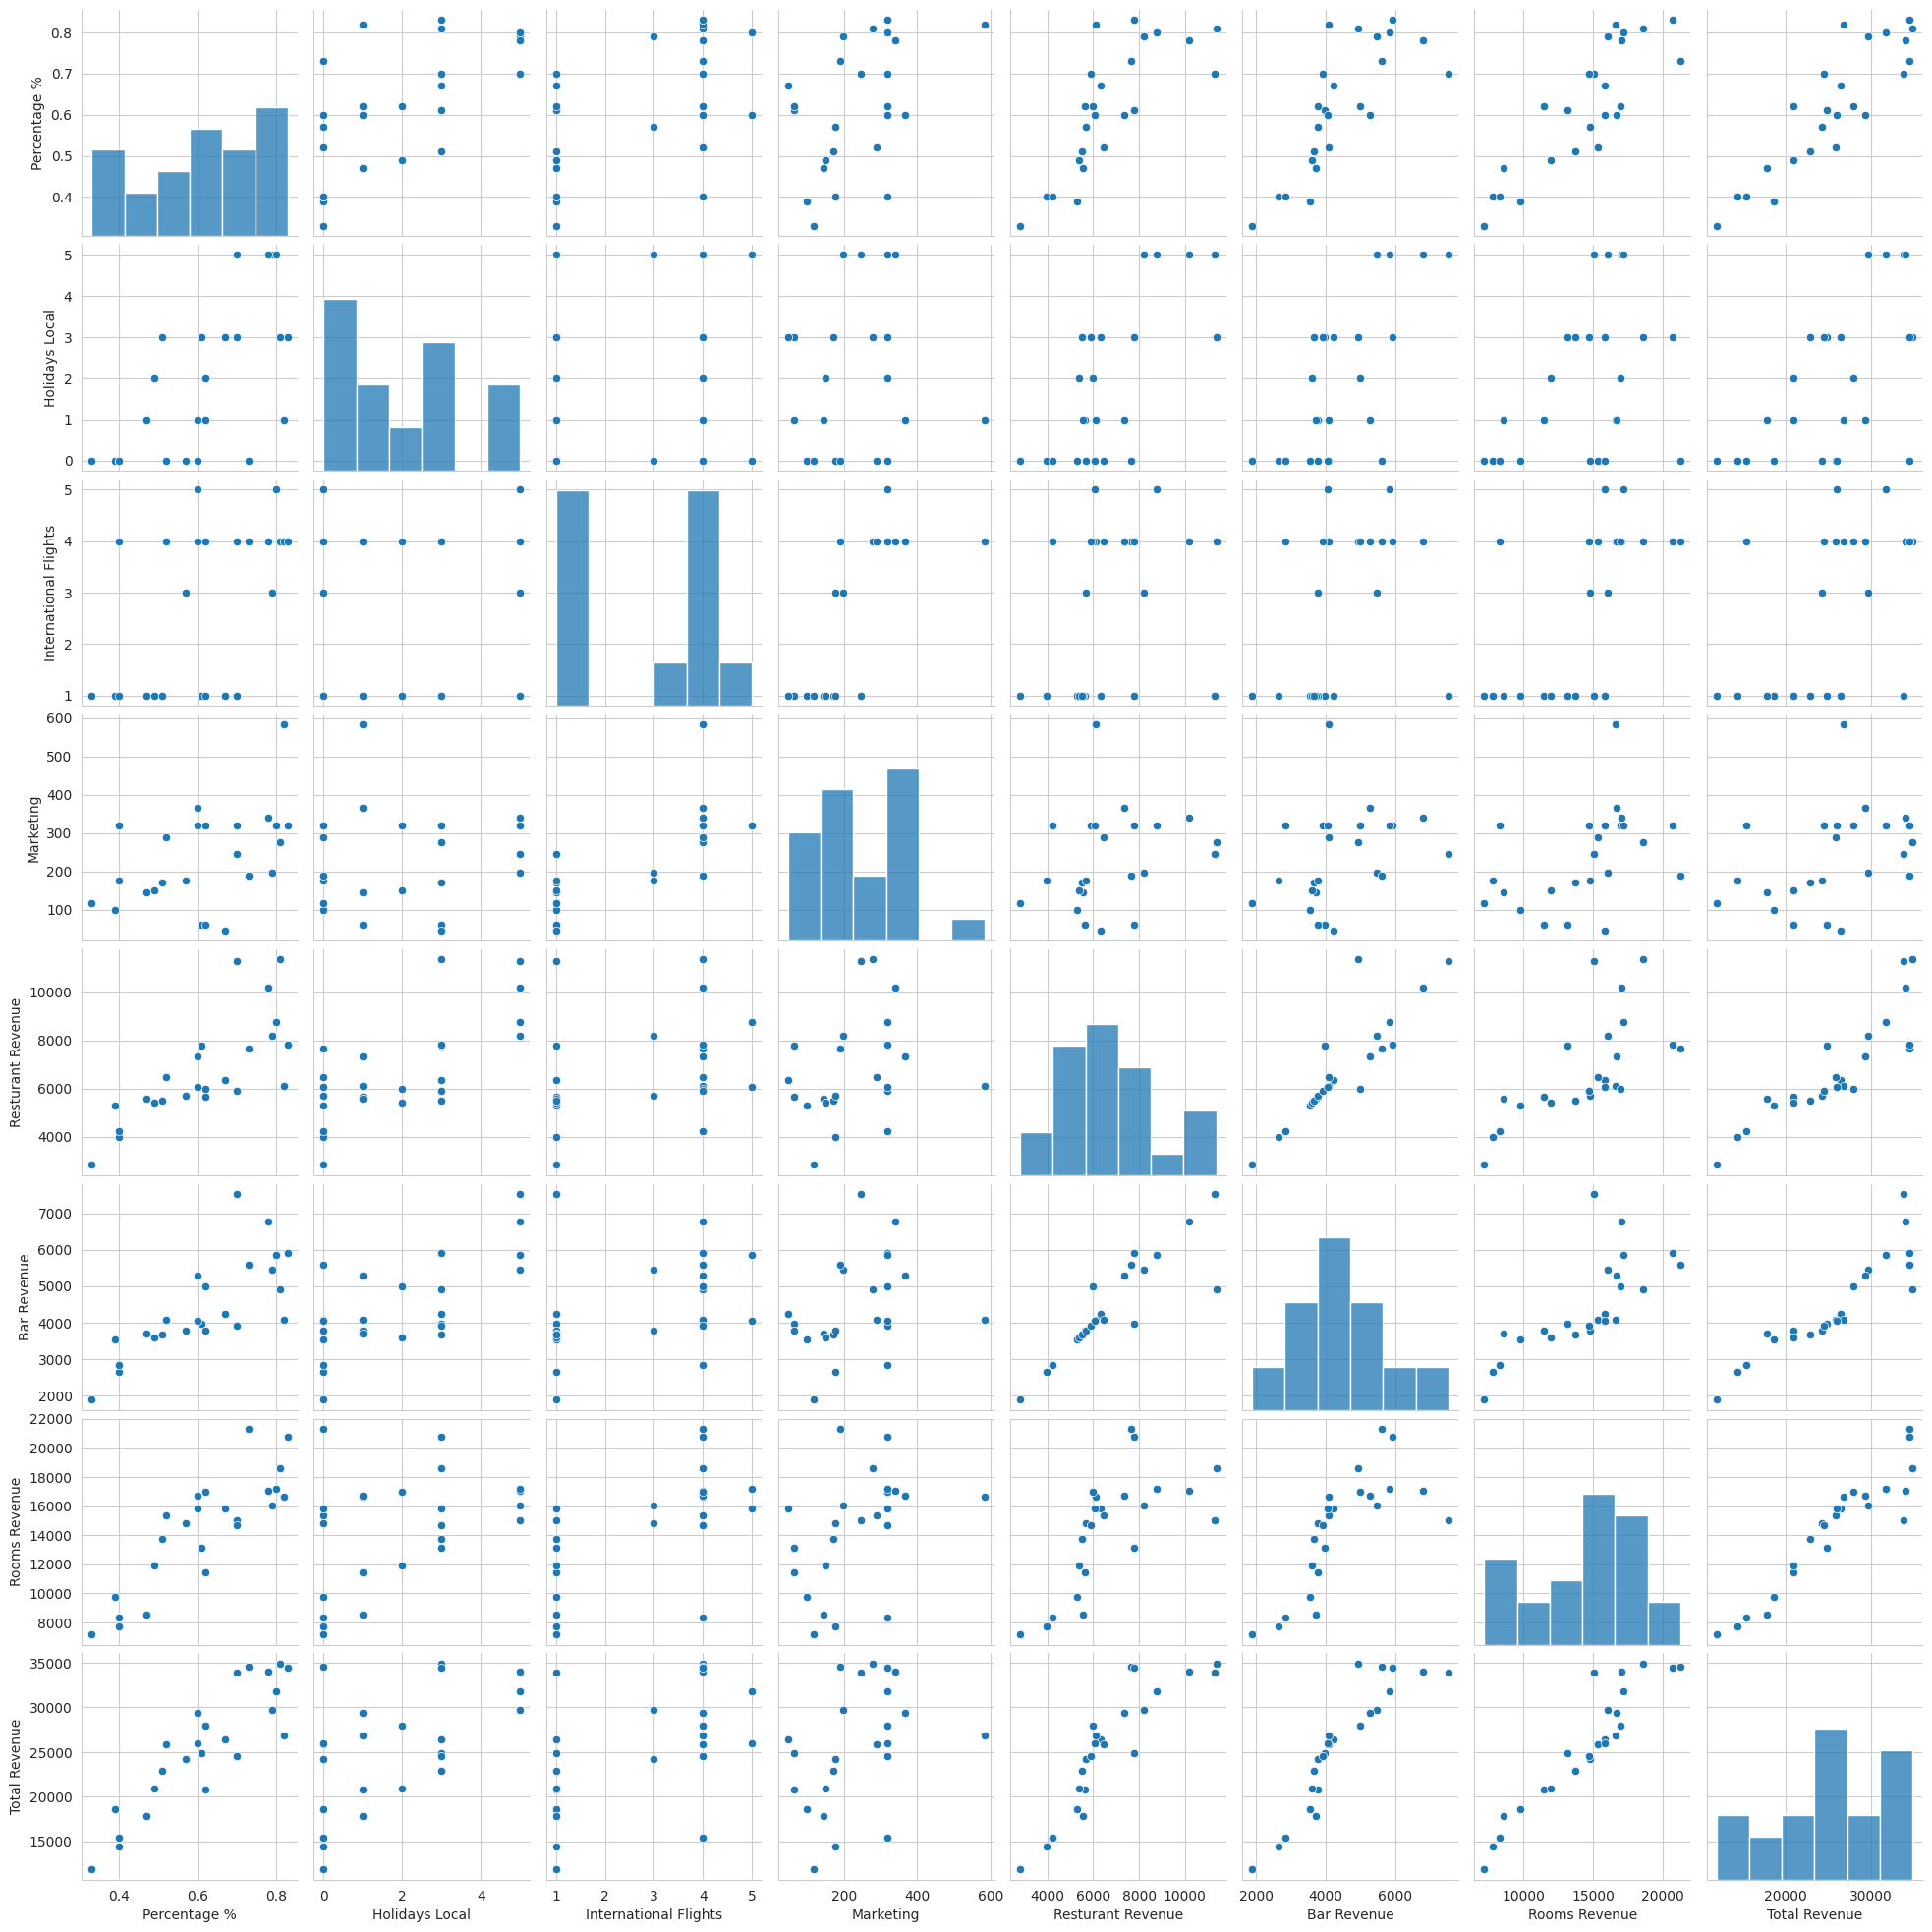

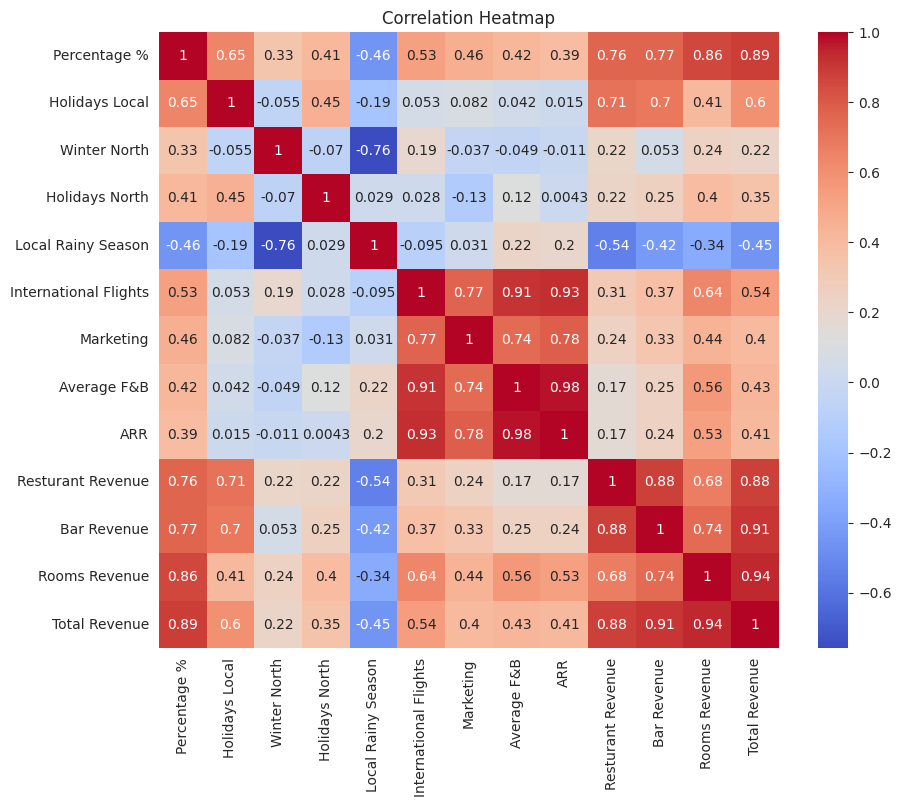

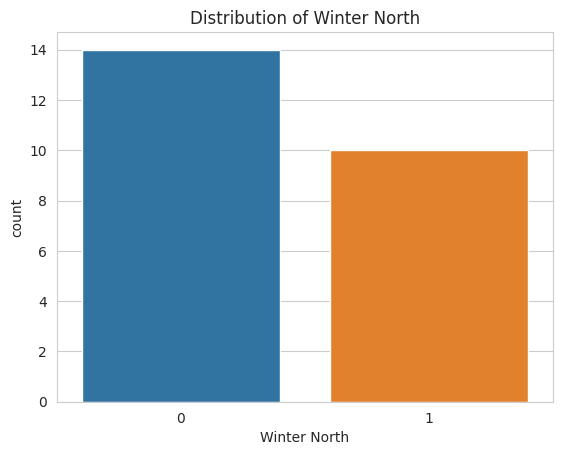

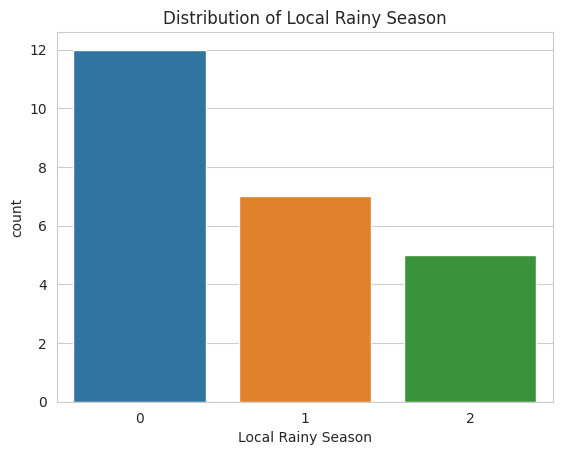

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables
sns.pairplot(df, vars=['Percentage %', 'Holidays Local', 'International Flights', 'Marketing', 'Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Revenue'])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Bar plots for categorical variables
categorical_cols = ['Winter North', 'Local Rainy Season']
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()


### Time Series Analysis

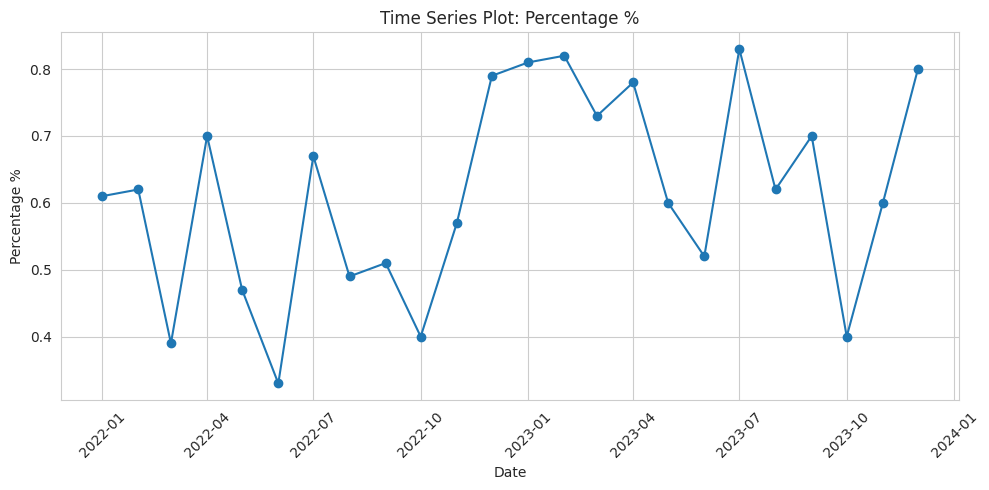

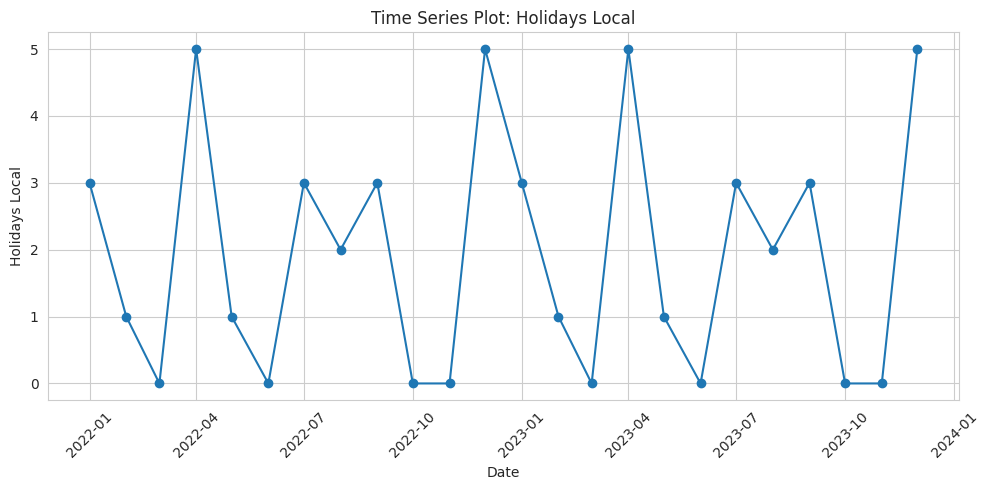

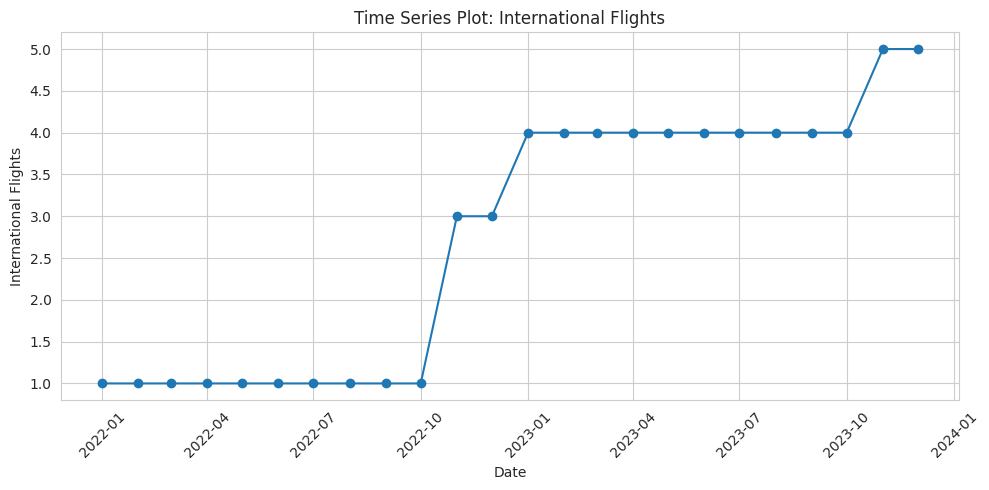

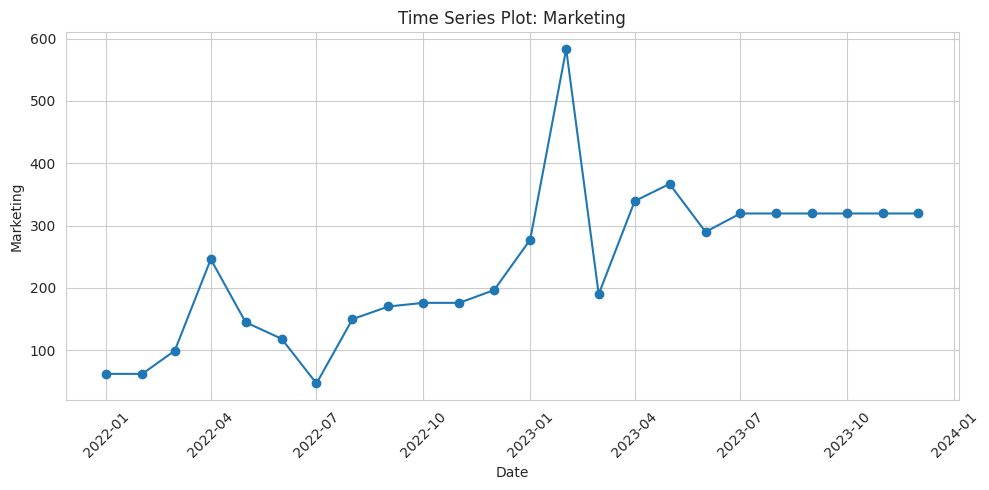

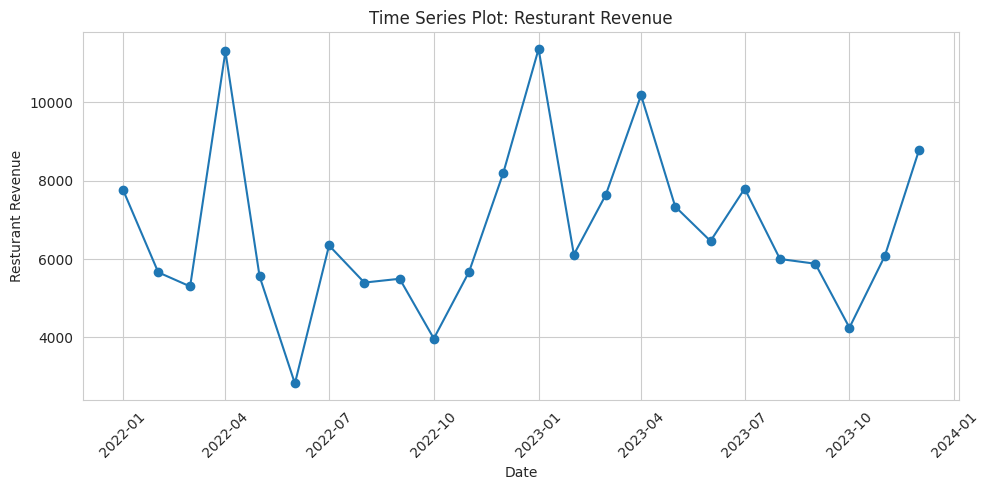

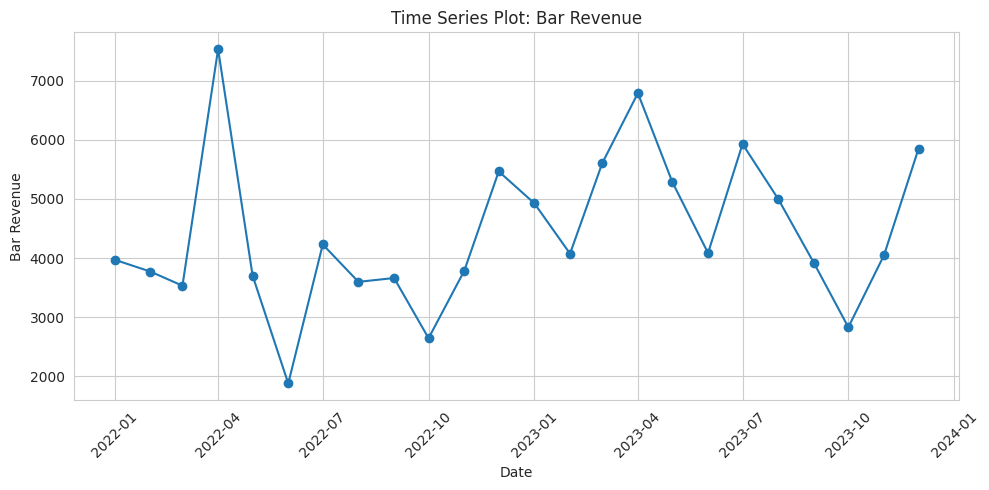

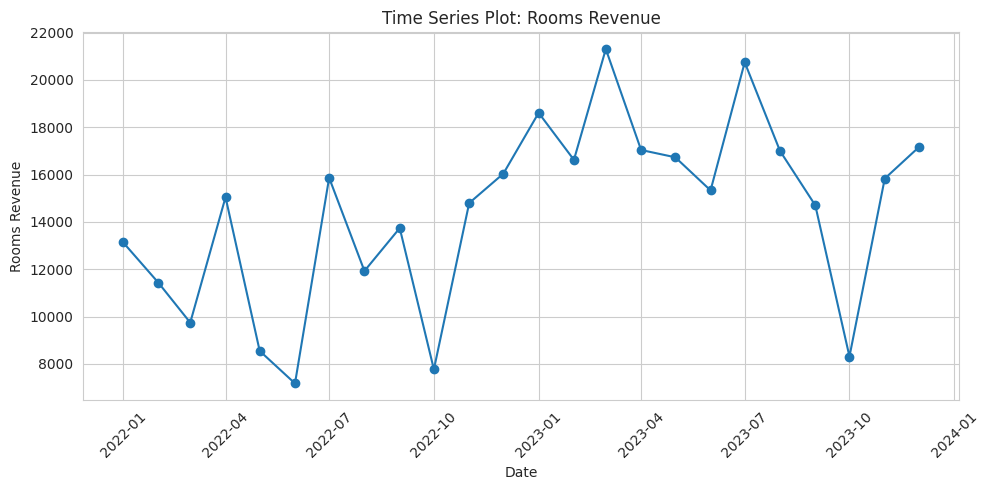

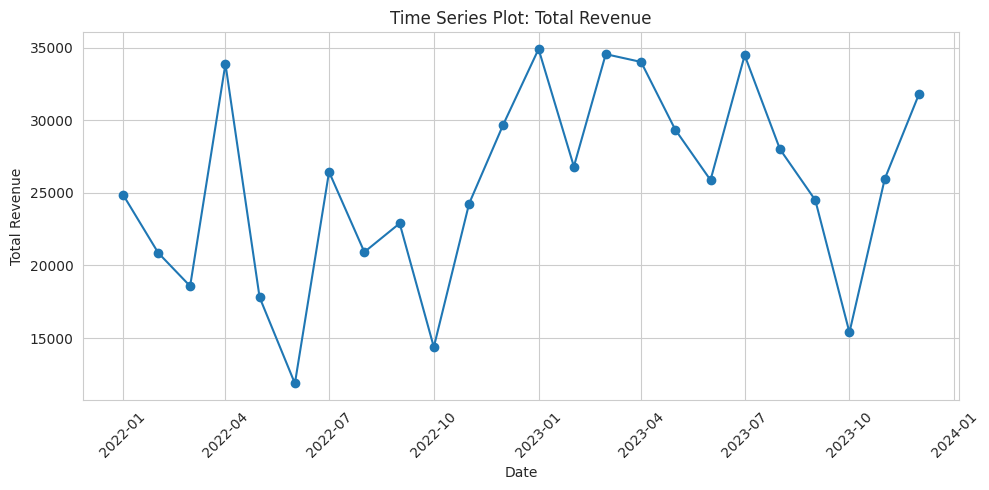

In [99]:
import matplotlib.pyplot as plt

# Select numerical columns for time series plots
numerical_columns = ['Percentage %', 'Holidays Local', 'International Flights', 'Marketing',
                     'Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Revenue']

# Plot time series for each numerical variable
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[col], marker='o')
    plt.title(f'Time Series Plot: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### BoxPlots

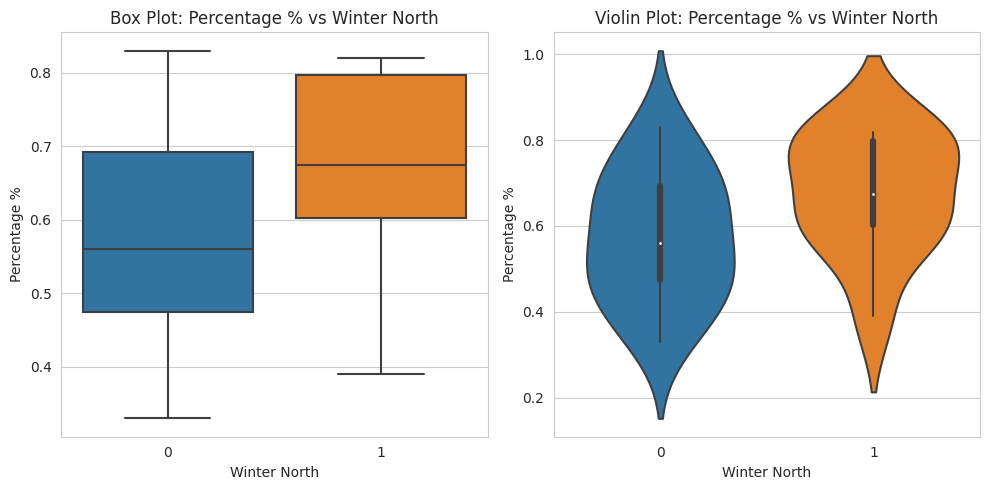

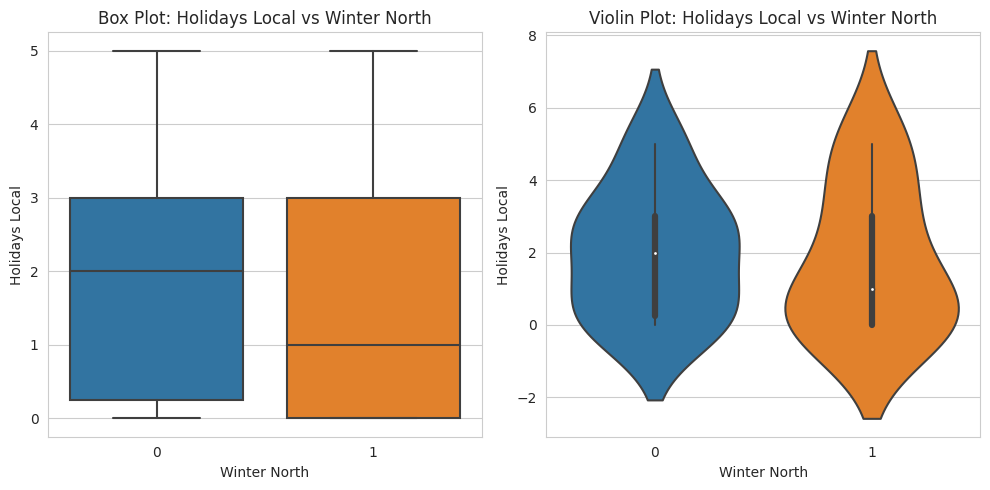

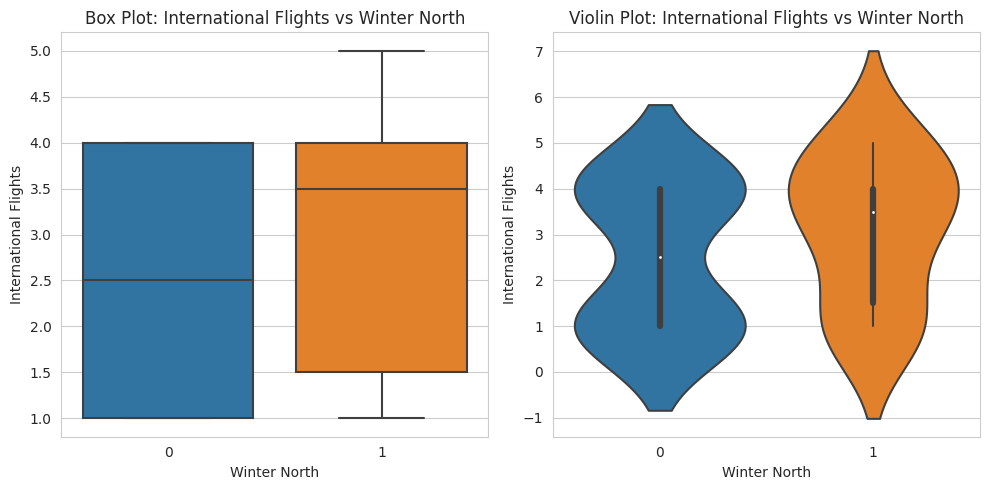

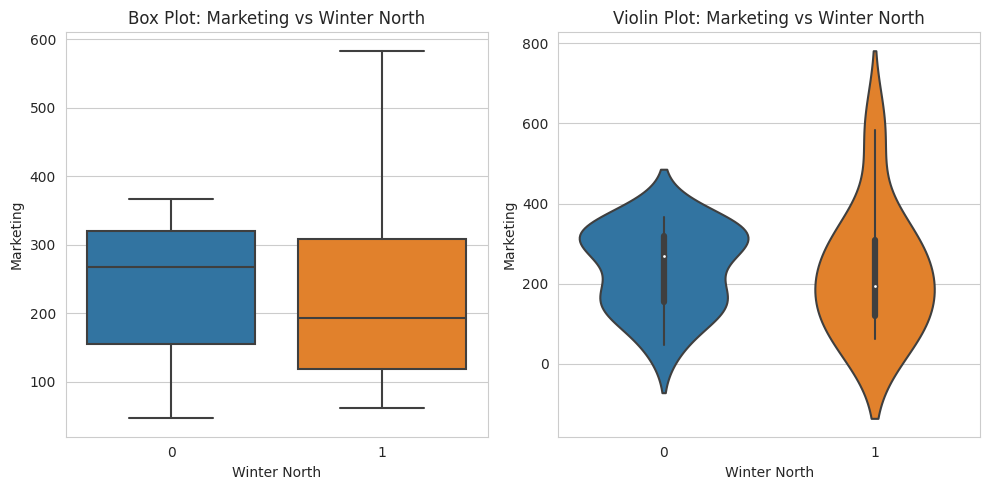

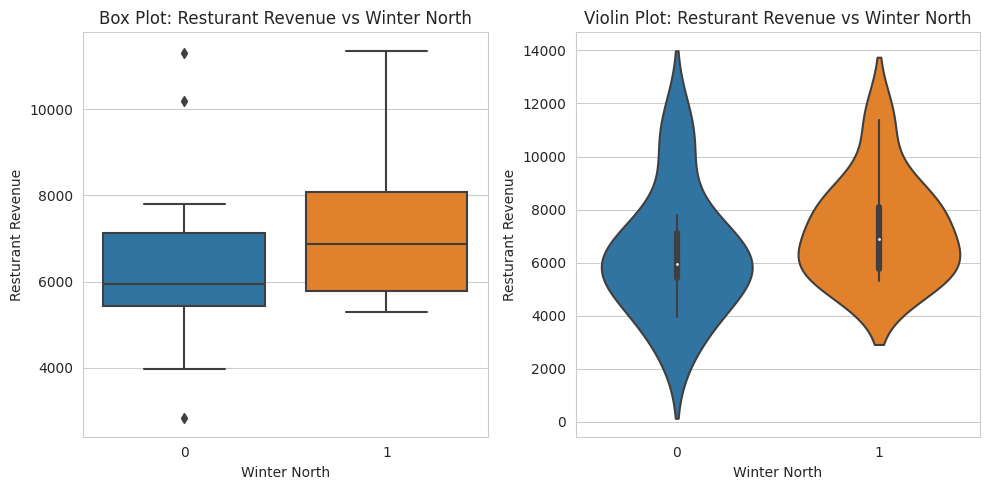

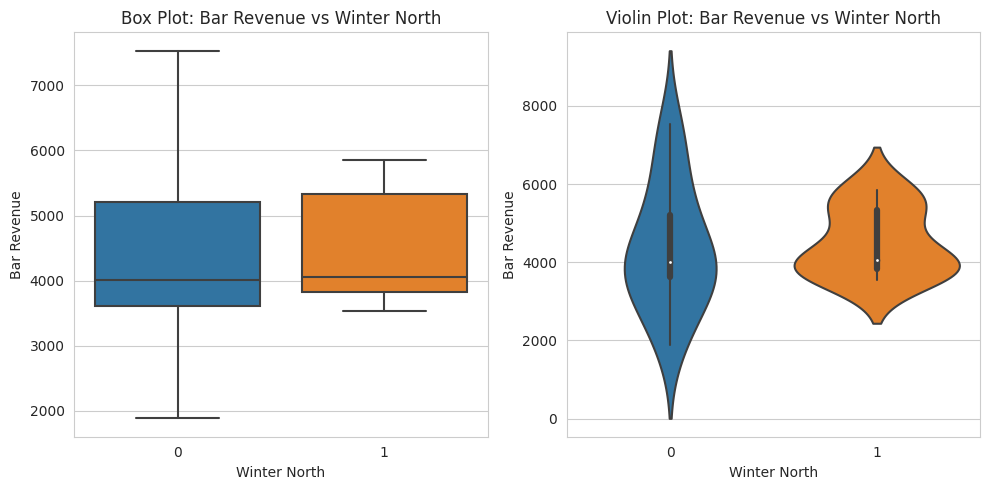

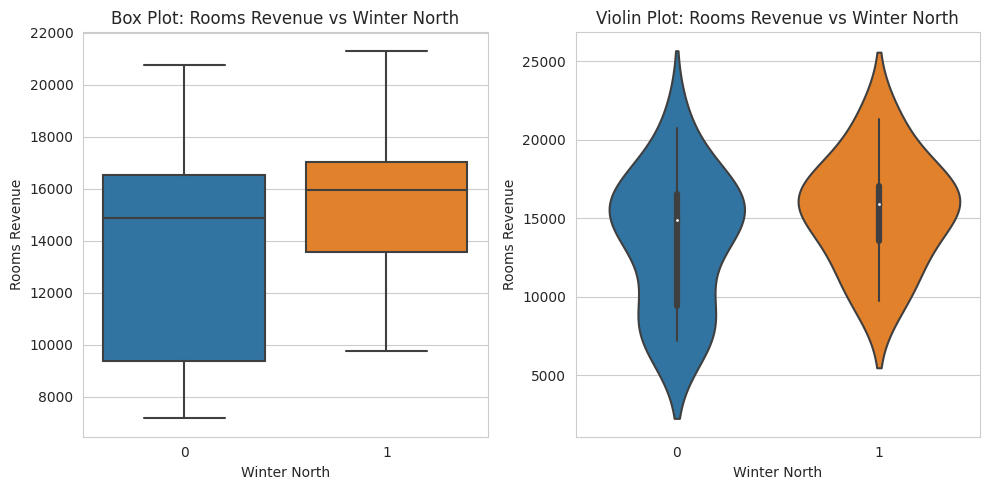

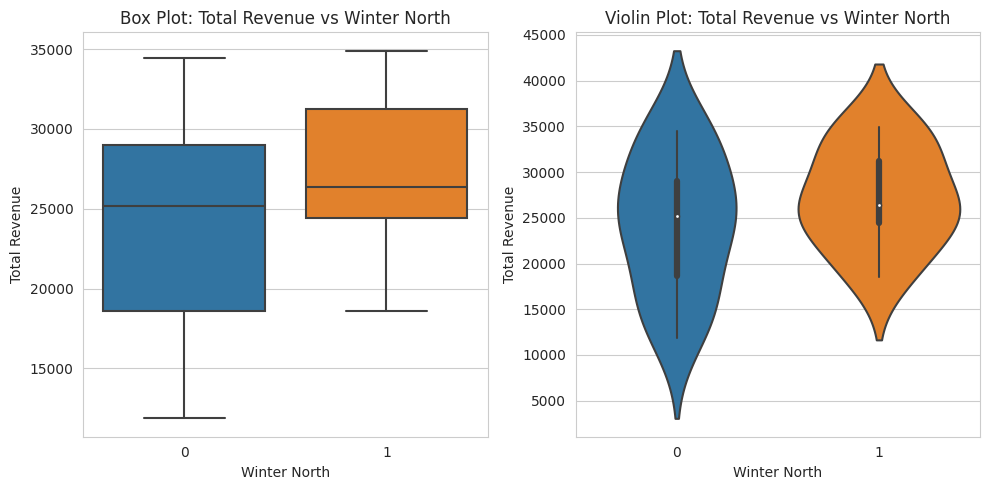

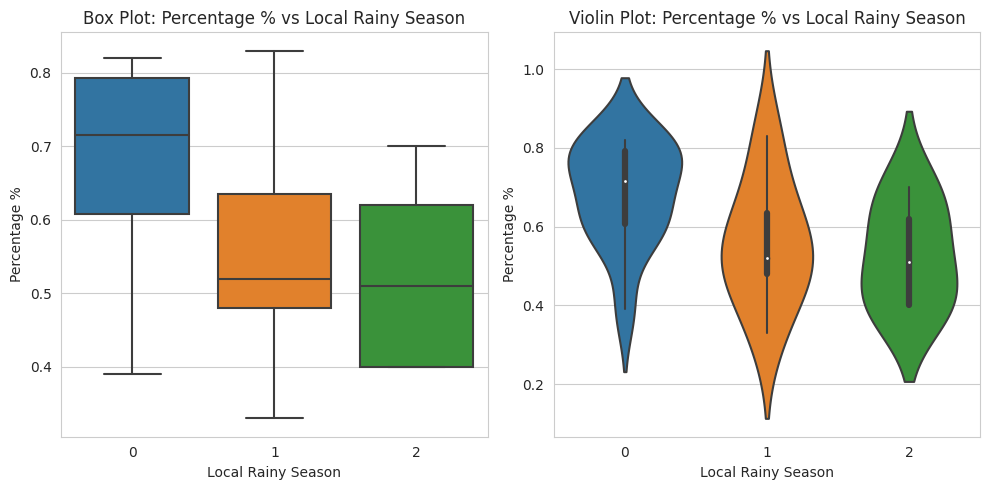

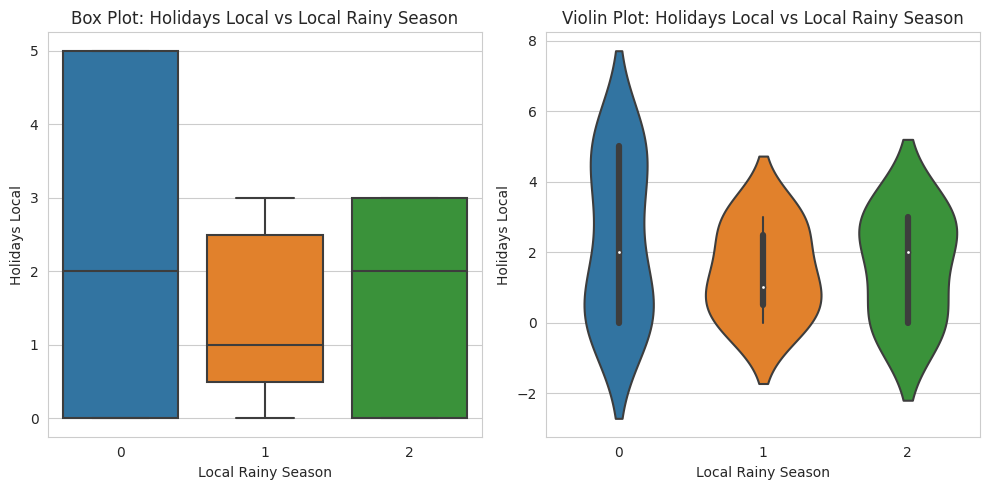

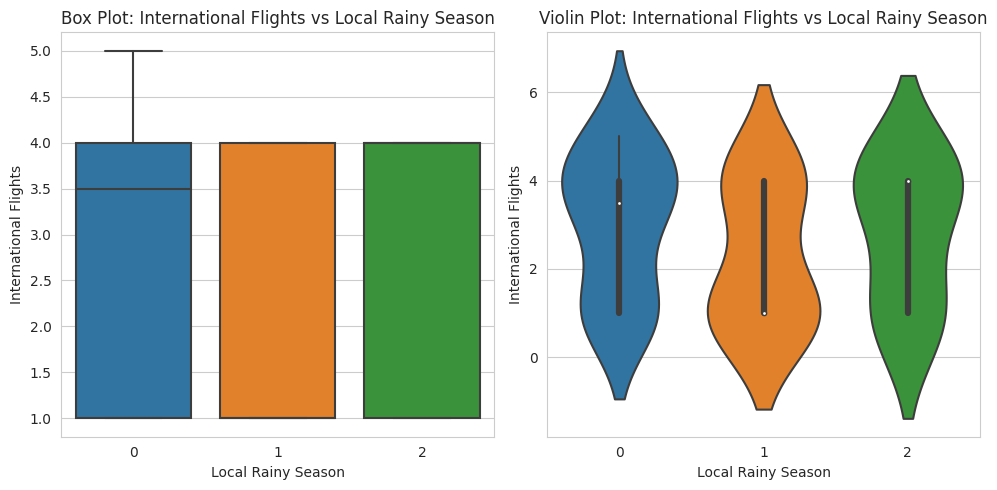

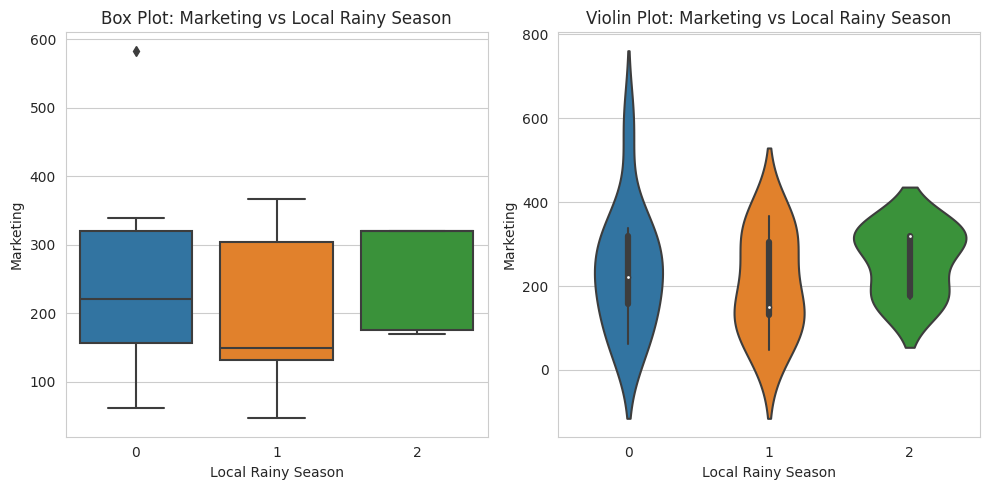

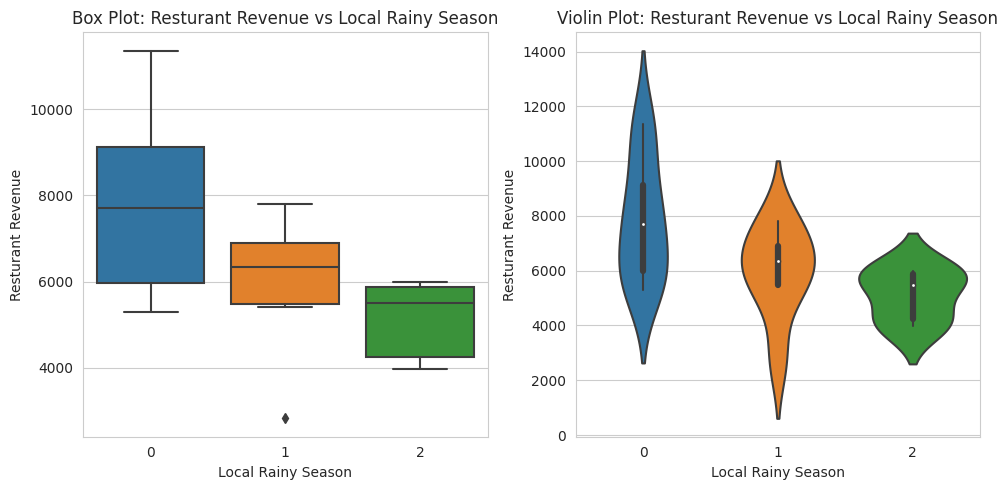

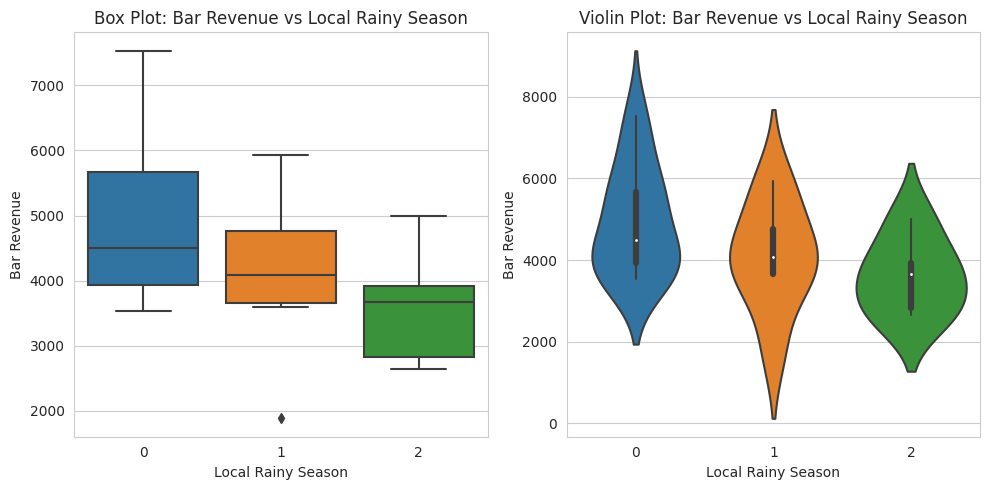

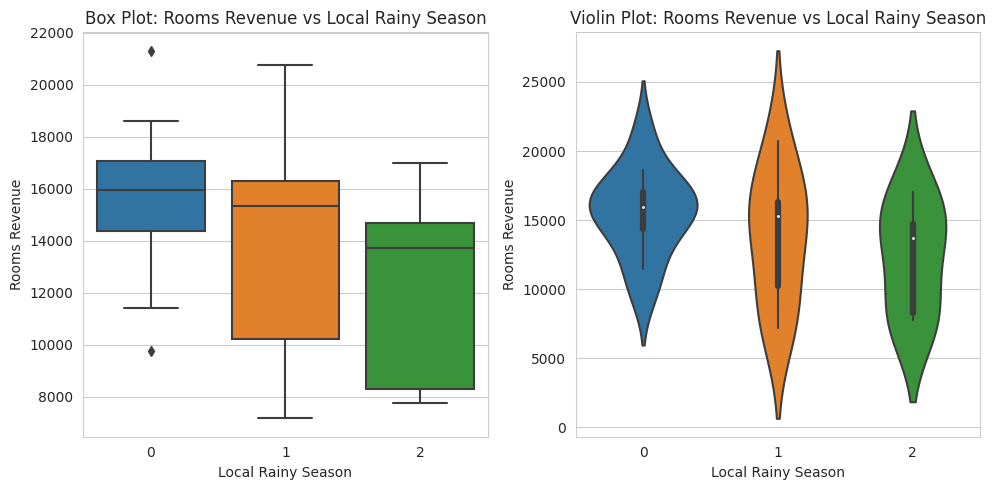

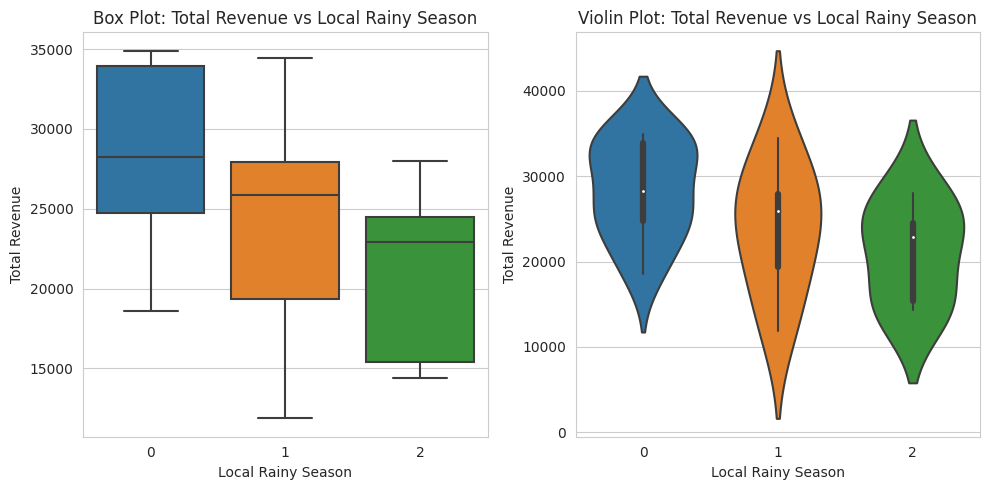

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select categorical and numerical columns for visualization
categorical_columns = ['Winter North', 'Local Rainy Season']
numerical_columns = ['Percentage %', 'Holidays Local', 'International Flights', 'Marketing',
                     'Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Revenue']

# Create box plots and violin plots for numerical variables across different categories
for cat_col in categorical_columns:
    for num_col in numerical_columns:
        plt.figure(figsize=(10, 5))
        
        # Create a box plot
        plt.subplot(1, 2, 1)
        sns.boxplot(x=cat_col, y=num_col, data=df)
        plt.title(f'Box Plot: {num_col} vs {cat_col}')
        
        # Create a violin plot
        plt.subplot(1, 2, 2)
        sns.violinplot(x=cat_col, y=num_col, data=df)
        plt.title(f'Violin Plot: {num_col} vs {cat_col}')
        
        plt.tight_layout()
        plt.show()


### Outlier Detector

In [102]:
import numpy as np
from scipy import stats

# Select numerical columns for outlier detection
numerical_columns = ['Percentage %', 'Holidays Local', 'International Flights', 'Marketing',
                     'Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Revenue']

# Calculate Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[numerical_columns]))

# Set a threshold for Z-score (e.g., 3) to identify extreme values
z_threshold = 3

# Find indices of potential outliers for each column
outlier_indices = np.where(z_scores > z_threshold)

# Print the indices of potential outliers
for i, col in enumerate(numerical_columns):
    potential_outliers = df.index[outlier_indices[0][outlier_indices[1] == i]]
    if len(potential_outliers) > 0:
        print(f'Potential outliers for {col}: {potential_outliers}')
    else:
        print(f'No potential outliers for {col}')

# Remove potential outliers if necessary
# df_cleaned = df.drop(index=potential_outliers)


No potential outliers for Percentage %
No potential outliers for Holidays Local
No potential outliers for International Flights
No potential outliers for Marketing
No potential outliers for Resturant Revenue
No potential outliers for Bar Revenue
No potential outliers for Rooms Revenue
No potential outliers for Total Revenue


### Seasonality Trend

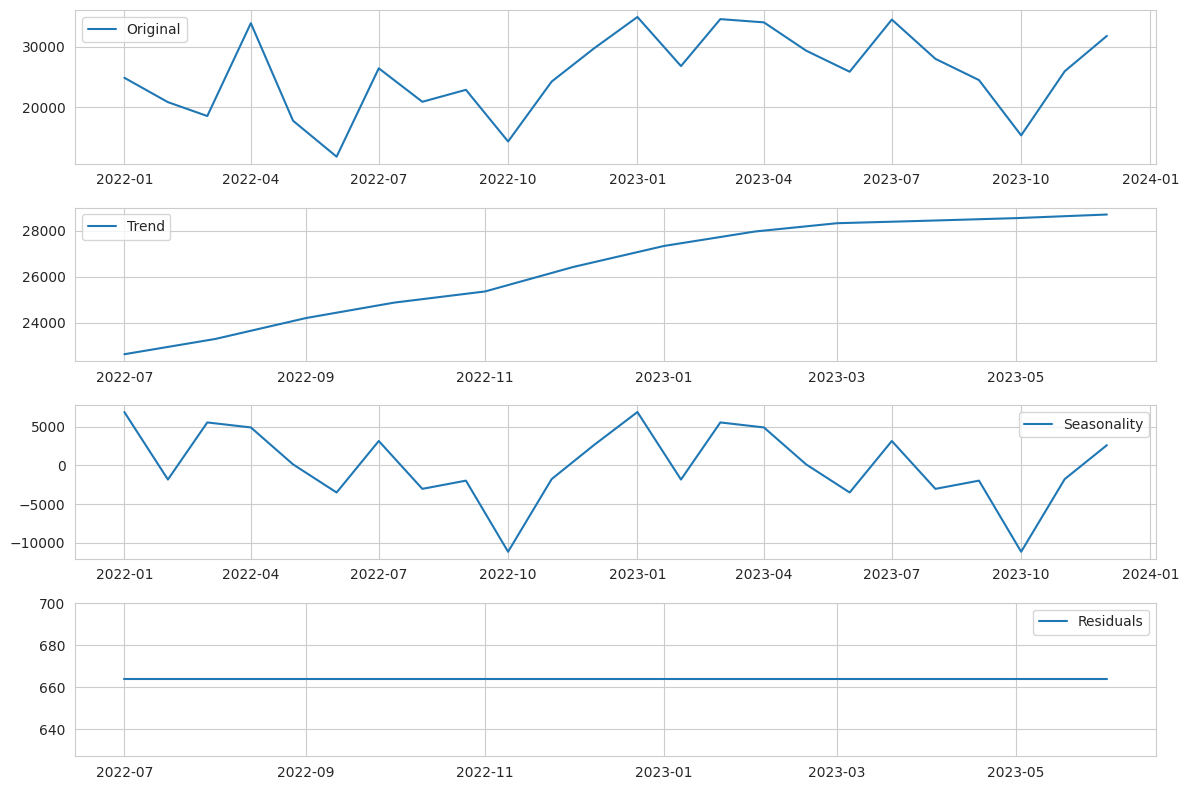

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your time series data into a DataFrame
# Assuming 'df' is your DataFrame with Date as the index and numerical variables

# Select the column you want to decompose
column_name = 'Total Revenue'

# Perform time series decomposition
result = seasonal_decompose(df[column_name], model='additive')

# Plot the decomposition components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df[column_name], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


### Autocorrelation Analysis 

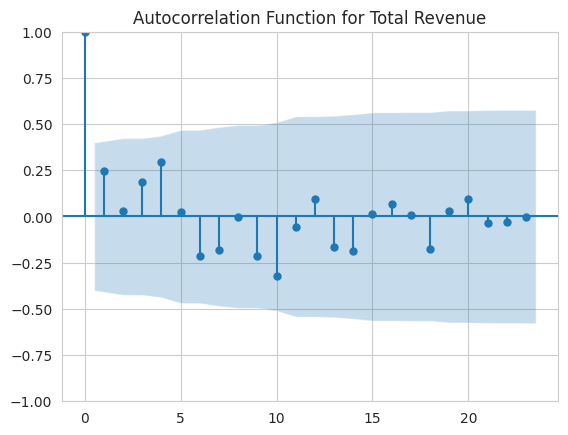

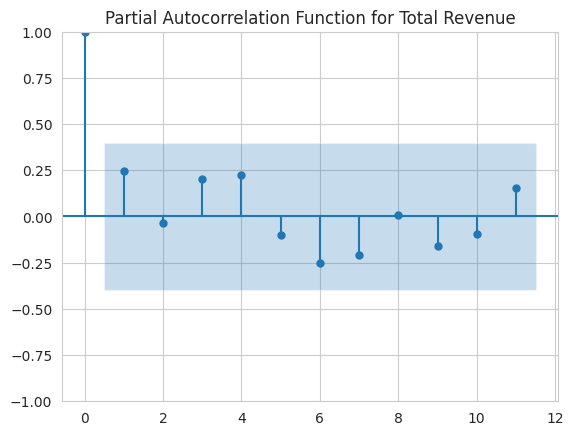

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df is your DataFrame with the revenue-related variable
revenue_variable = "Total Revenue"  # Change this to the actual column name

# Plot Autocorrelation Function (ACF)
plot_acf(df[revenue_variable], lags=23)  # Adjust lags here
plt.title(f"Autocorrelation Function for {revenue_variable}")
plt.show()

# Plot Partial Autocorrelation Function (PACF)
plot_pacf(df[revenue_variable], lags=11)  # Set lags to a value less than 12
plt.title(f"Partial Autocorrelation Function for {revenue_variable}")
plt.show()


### Distribution

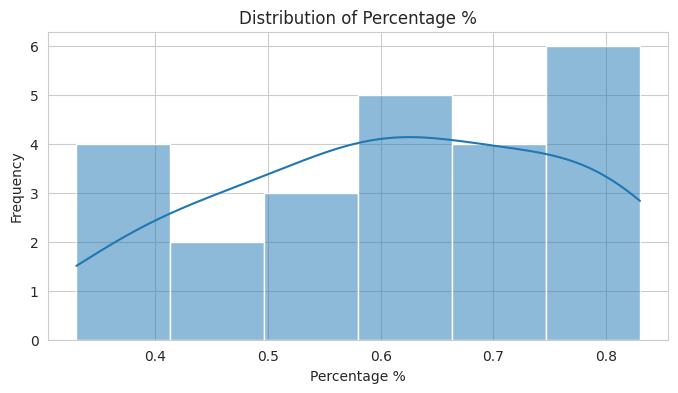

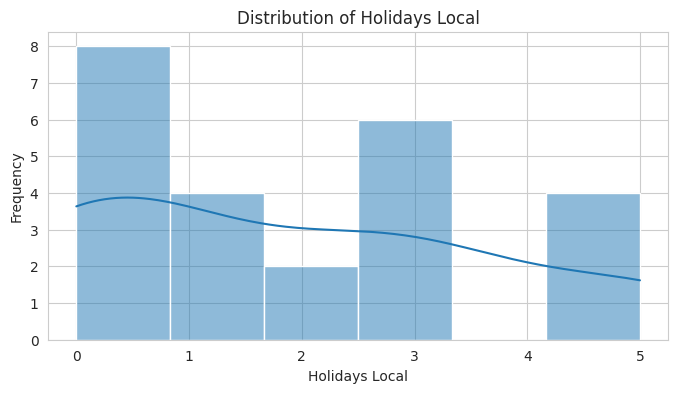

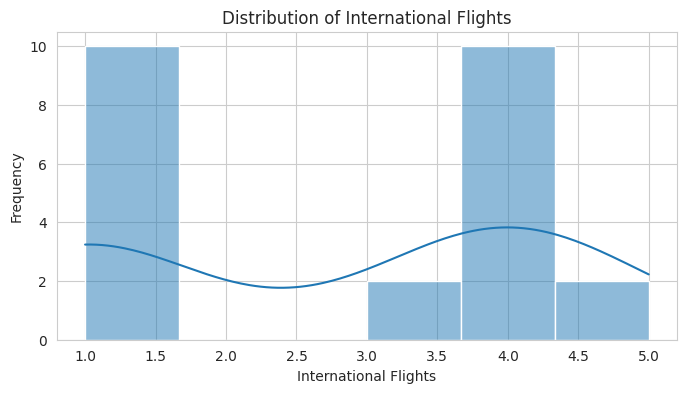

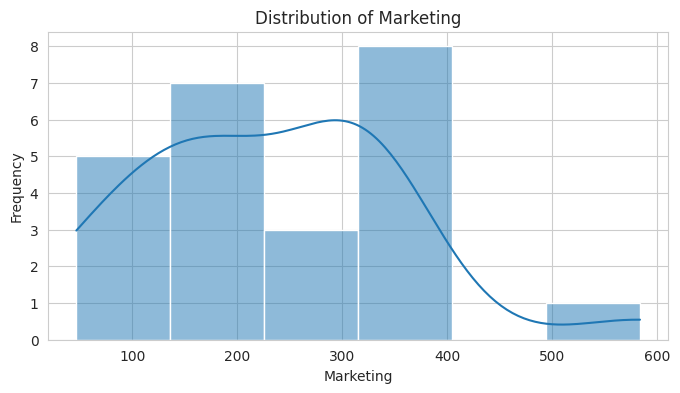

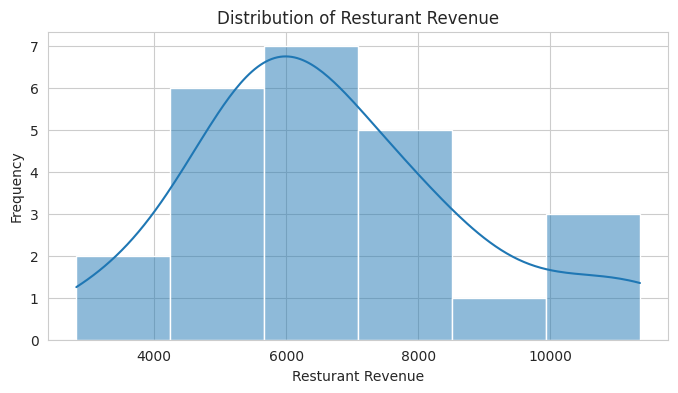

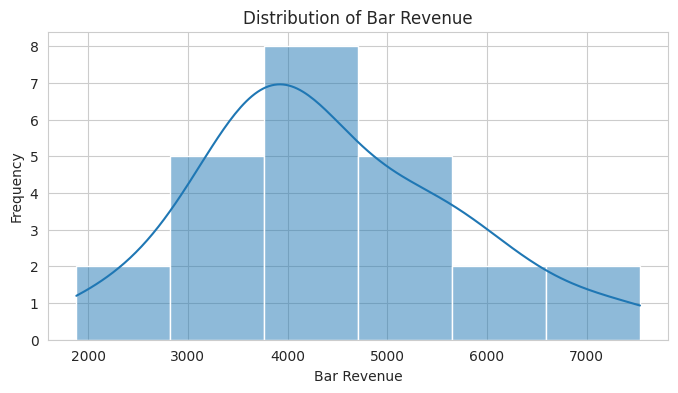

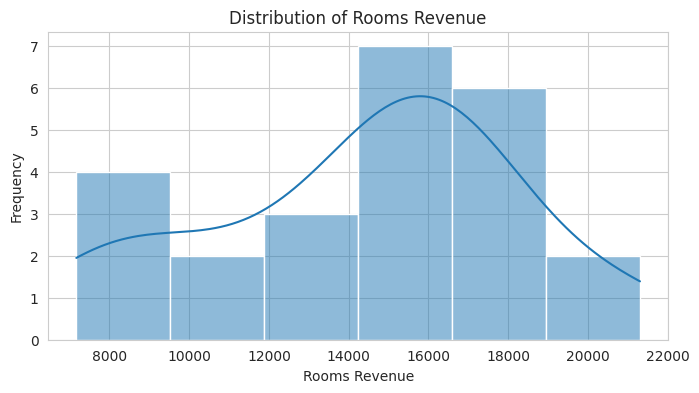

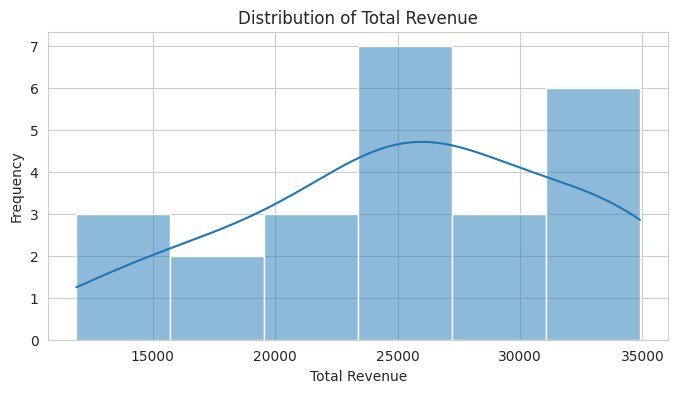

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
numerical_cols = ['Percentage %', 'Holidays Local', 'International Flights', 'Marketing', 'Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Revenue']

# Plot distribution plots for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


### Shapiro-Wilk Normal Distribution

In [110]:
from scipy.stats import shapiro

# Assuming df is your DataFrame
numerical_cols = ['Percentage %', 'Holidays Local', 'International Flights', 'Marketing', 'Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Revenue']

# Perform Shapiro-Wilk test for normality
for col in numerical_cols:
    data = df[col].dropna()  # Remove missing values
    stat, p_value = shapiro(data)
    print(f"Variable: {col}")
    print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value > 0.05:
        print("The data is likely normally distributed (fail to reject H0)")
    else:
        print("The data is not normally distributed (reject H0)")
    print()


Variable: Percentage %
Shapiro-Wilk Test Statistic: 0.9466
P-value: 0.2286
The data is likely normally distributed (fail to reject H0)

Variable: Holidays Local
Shapiro-Wilk Test Statistic: 0.8472
P-value: 0.0019
The data is not normally distributed (reject H0)

Variable: International Flights
Shapiro-Wilk Test Statistic: 0.7597
P-value: 0.0001
The data is not normally distributed (reject H0)

Variable: Marketing
Shapiro-Wilk Test Statistic: 0.9245
P-value: 0.0734
The data is likely normally distributed (fail to reject H0)

Variable: Resturant Revenue
Shapiro-Wilk Test Statistic: 0.9338
P-value: 0.1188
The data is likely normally distributed (fail to reject H0)

Variable: Bar Revenue
Shapiro-Wilk Test Statistic: 0.9578
P-value: 0.3956
The data is likely normally distributed (fail to reject H0)

Variable: Rooms Revenue
Shapiro-Wilk Test Statistic: 0.9452
P-value: 0.2124
The data is likely normally distributed (fail to reject H0)

Variable: Total Revenue
Shapiro-Wilk Test Statistic: 0.95

### Check for Missing Values

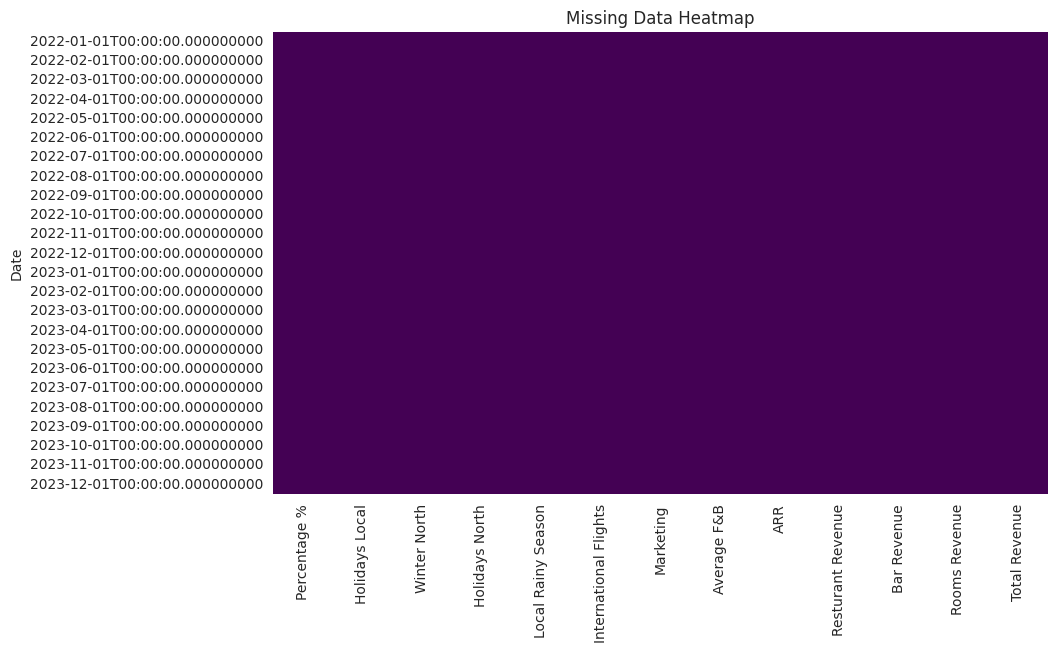

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()


In [114]:
df.isnull().sum()

Percentage %             0
Holidays Local           0
Winter North             0
Holidays North           0
Local Rainy Season       0
International Flights    0
Marketing                0
Average F&B              0
ARR                      0
Resturant Revenue        0
Bar Revenue              0
Rooms Revenue            0
Total Revenue            0
dtype: int64